In [8]:
import pandas_datareader
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

df_price = pandas_datareader.DataReader(
    "BA", "yahoo", datetime.datetime(2011, 2, 20), datetime.datetime(2021, 3, 17)
)

scaler = MinMaxScaler()
scale_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_columns])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_columns
# print(df_scaled)

In [9]:
TEST_SIZE = 180
train = df_scaled[:-TEST_SIZE]  # 총 dataframe에서 TestSize뺀거만큼
test = df_scaled[-TEST_SIZE:]   # 총 dataframe에서 최근 데이터를 TestSize만큼 자른거

# make_dataset funtion은 window_size만큼의 길이를 가진 데이터로 편집 eg. window_size가 2라면
# [
#     [[0일차][1일차]]
#     [[1일차][2일차]]
#     [[...][...]]
# ]
# 꼴로 만들어준다. windowsize는 내가 며칠간의 데이터로 다음날 값을 예측할지 정하는 값이다. 너무 길면 급격한 변동에 대응이 안될거고 너무 짧으면 정확도가 떨어질듯
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


In [10]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

# 최근 200일은 test data 그거 뺀 나머지는 train data
train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]


# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 14)

# train, validation set 생성
# train과 validation set을 나누는 건 Overfitting을 방지하기 위한 수단이다.
# https://teddylee777.github.io/scikit-learn/train-test-split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
 
print(train_feature.shape, x_train.shape, x_valid.shape)
# x_train은 총 data에서 0.8만큼의 train할 데이터 x_valid는 총 data에서 validation 할 0.2 만큼의 data로 잘린걸 알 수 있다. 28->22, 6으로 나뉨 20,4는 windowsize와 featurecols로 일정하다. x,y는 각각 train_feature train_label

# 실제 예측 해 볼 데이터 testdata (최근 TEST_SIZE day만큼)
test_feature, test_label = make_dataset(test_feature, test_label, 14)
print(test_feature.shape, test_label.shape)


(2340, 14, 4) (1872, 14, 4) (468, 14, 4)
(166, 14, 4) (166, 1)


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [12]:
# from keras import optimizers
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.99, nesterov=True)

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=sgd)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'C:/98_Git/Porsche_Buying_Project/PBP/Temp/'
filename = os.path.join(model_path, '10yrsdata_14dayswindow_adam.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
117/117 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 8.4493e-04

Epoch 00001: val_loss improved from inf to 0.00084, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\10yrsdata_14dayswindow_adam.h5
Epoch 2/200
117/117 [==============================] - 0s 2ms/step - loss: 8.7962e-04 - val_loss: 7.5595e-04

Epoch 00002: val_loss improved from 0.00084 to 0.00076, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\10yrsdata_14dayswindow_adam.h5
Epoch 3/200
117/117 [==============================] - 0s 2ms/step - loss: 7.4081e-04 - val_loss: 6.2055e-04

Epoch 00003: val_loss improved from 0.00076 to 0.00062, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\10yrsdata_14dayswindow_adam.h5
Epoch 4/200
117/117 [==============================] - 0s 2ms/step - loss: 4.7429e-04 - val_loss: 4.7896e-04

Epoch 00004: val_loss improved from 0.00062 to 0.00048, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\10yrsdata_14dayswin

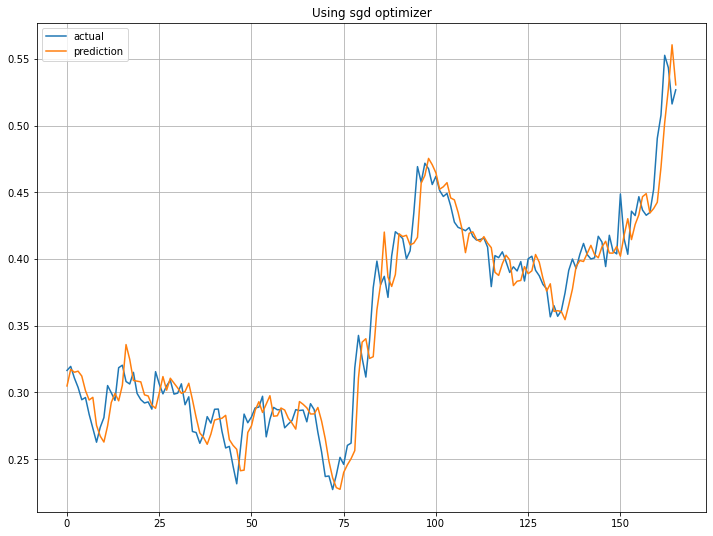

In [14]:
import matplotlib.pyplot as plt

model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.grid(True)
plt.plot(test_label, label="actual")
plt.plot(pred, label="prediction")
plt.legend()
plt.title('Using sgd optimizer')
plt.show()
